<a href="https://colab.research.google.com/github/Roll1ngo/Authorization_and_authentication_synopsis/blob/master/Hw_10_CNN_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скопійюємо код дослідження, підготовки даних та код моделі з попереднього завдання.

In [ ]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout, Conv2D
from keras.optimizers import Adam, RMSprop, AdamW, Lion
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2


import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import display

Підлаштуємо вивід графіків

 Завантажуємо данні

In [ ]:
(train_data_full, train_labels_full), (test_data_full, test_labels_full) = fashion_mnist.load_data()

## Змінимо розмір вхідних даних для коректної роботи згорткових слоїв VGG16

In [ ]:
train_data_cnn = tf.expand_dims(train_data_full, axis=-1)/255
test_data_cnn = tf.expand_dims(test_data_full, axis=-1)/255

train_data_resized = tf.image.resize(train_data_cnn, [48, 48])
test_data_resized = tf.image.resize(test_data_cnn, [48, 48])


train_data_rgb = tf.image.grayscale_to_rgb(train_data_resized)
test_data_rgb = tf.image.grayscale_to_rgb(test_data_resized)

train_labels_full = to_categorical(train_labels_full, 10)
test_labels_full = to_categorical(test_labels_full, 10)

train_data_rgb.shape, test_data_rgb.shape

(TensorShape([60000, 48, 48, 3]), TensorShape([10000, 48, 48, 3]))

Візьмемо згорткові слої

In [ ]:
conv_layers_vgg16 = VGG16(weights="imagenet", include_top=False,
                          input_shape=(48, 48, 3))

З заморожуванням всіх слоїв точнічть не перевищує 89%. Будемо поступово залучати останні згорткові слої до навчання разом з повнов'язними шарами.

In [ ]:

n = 13

for layer in conv_layers_vgg16.layers[:n]:
    layer.trainable = False


for layer in conv_layers_vgg16.layers[n:]:
    layer.trainable = True

## Створемо модель зі згорткових слоїв моделі  VGG16 та додамо повнов'язні шари для класифікації наших даних.

In [ ]:
x = conv_layers_vgg16.output
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.1))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=conv_layers_vgg16.input, outputs=output)

batch_size = 128
early_stopping_callback = EarlyStopping(patience=10)
optimizer_= RMSprop(learning_rate=0.0001)

model.compile(optimizer=optimizer_,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(train_data_rgb,
                    train_labels_full,
                    validation_data=(test_data_rgb, test_labels_full),
                    batch_size=batch_size,
                    callbacks=[early_stopping_callback],
                    epochs=20)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0  

Тренуємо

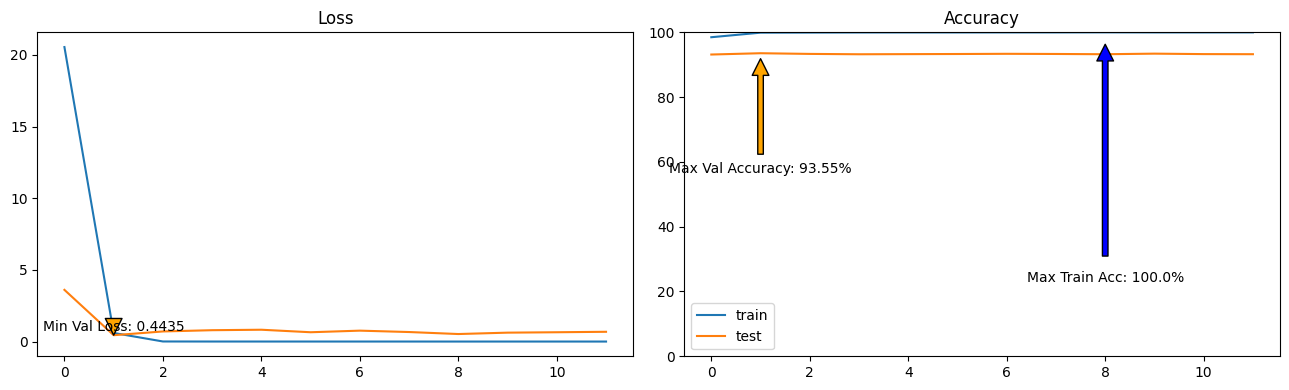

In [ ]:
  hіstory=history
  plt.figure(figsize=(13,4))


  plt.subplot(1, 2, 1)
  plt.plot(hіstory.history['loss'], label='train')
  plt.plot(hіstory.history['val_loss'], label='test')
  plt.title('Loss')


  min_val_loss = min(hіstory.history['val_loss'])
  min_val_loss_epoch = hіstory.history['val_loss'].index(min_val_loss)

  plt.annotate(f'Min Val Loss: {min_val_loss:.4f}',
                xy=(min_val_loss_epoch, min_val_loss),
                xytext=(min_val_loss_epoch, min_val_loss + 0.3),
                arrowprops=dict(facecolor='orange', shrink=0.05),
                horizontalalignment='center')

  plt.subplot(1, 2, 2)
  plt.plot([round(100*e,2) for e in hіstory.history['accuracy']], label='train')
  plt.plot([round(100*e,2) for e in hіstory.history['val_accuracy']], label='test')
  plt.title('Accuracy')
  plt.ylim(0, 100)
  plt.legend()

  max_train_accuracy = max(hіstory.history['accuracy'])
  max_train_accuracy_epoch = hіstory.history['accuracy'].index(max_train_accuracy)
  max_train_accuracy_percentage = round(100 * max_train_accuracy, 2)


  plt.annotate(f'Max Train Acc: {max_train_accuracy_percentage}%',
                xy=(max_train_accuracy_epoch, max_train_accuracy_percentage),
                xytext=(max_train_accuracy_epoch,max_train_accuracy_epoch + 15),
                arrowprops=dict(facecolor='blue', shrink=0.05),
                horizontalalignment='center')

  max_val_accuracy = max(hіstory.history['val_accuracy'])
  max_val_accuracy_epoch = hіstory.history['val_accuracy'].index(max_val_accuracy)
  max_val_accuracy_percentage = round(100 * max_val_accuracy, 2)


  plt.annotate(f'Max Val Accuracy: {max_val_accuracy_percentage}%',
                xy=(max_val_accuracy_epoch, max_val_accuracy_percentage),
                xytext=(max_val_accuracy_epoch, max_val_accuracy +55.5),
                arrowprops=dict(facecolor='orange', shrink=0.05),
                horizontalalignment='center')

  plt.tight_layout()
  plt.show()

Висновки: Попередньо навчену згоркову частину доцільно використовувати в задачах де вхідні данні співпадають з данними на яких тренувалася модель, що значно скорочують час і обчислювальні ресурси, необхідні для навчання. Це обумовлено тим, що такі моделі вже мають узагальнені знання про розпізнавання об'єктів. Але якщо дані дуже специфічні, то написання моделі з "нуля" дасть кращі результати ніж використання непідходящої згорткової основи. Однак, навчання з нуля вимагає значних обчислювальних ресурсів та часу. Це може бути непрактично для окремих розробників або малих команд. Тому ,як завжди, важливий баланс при виборі інструментів для вирішення поставлених задач.